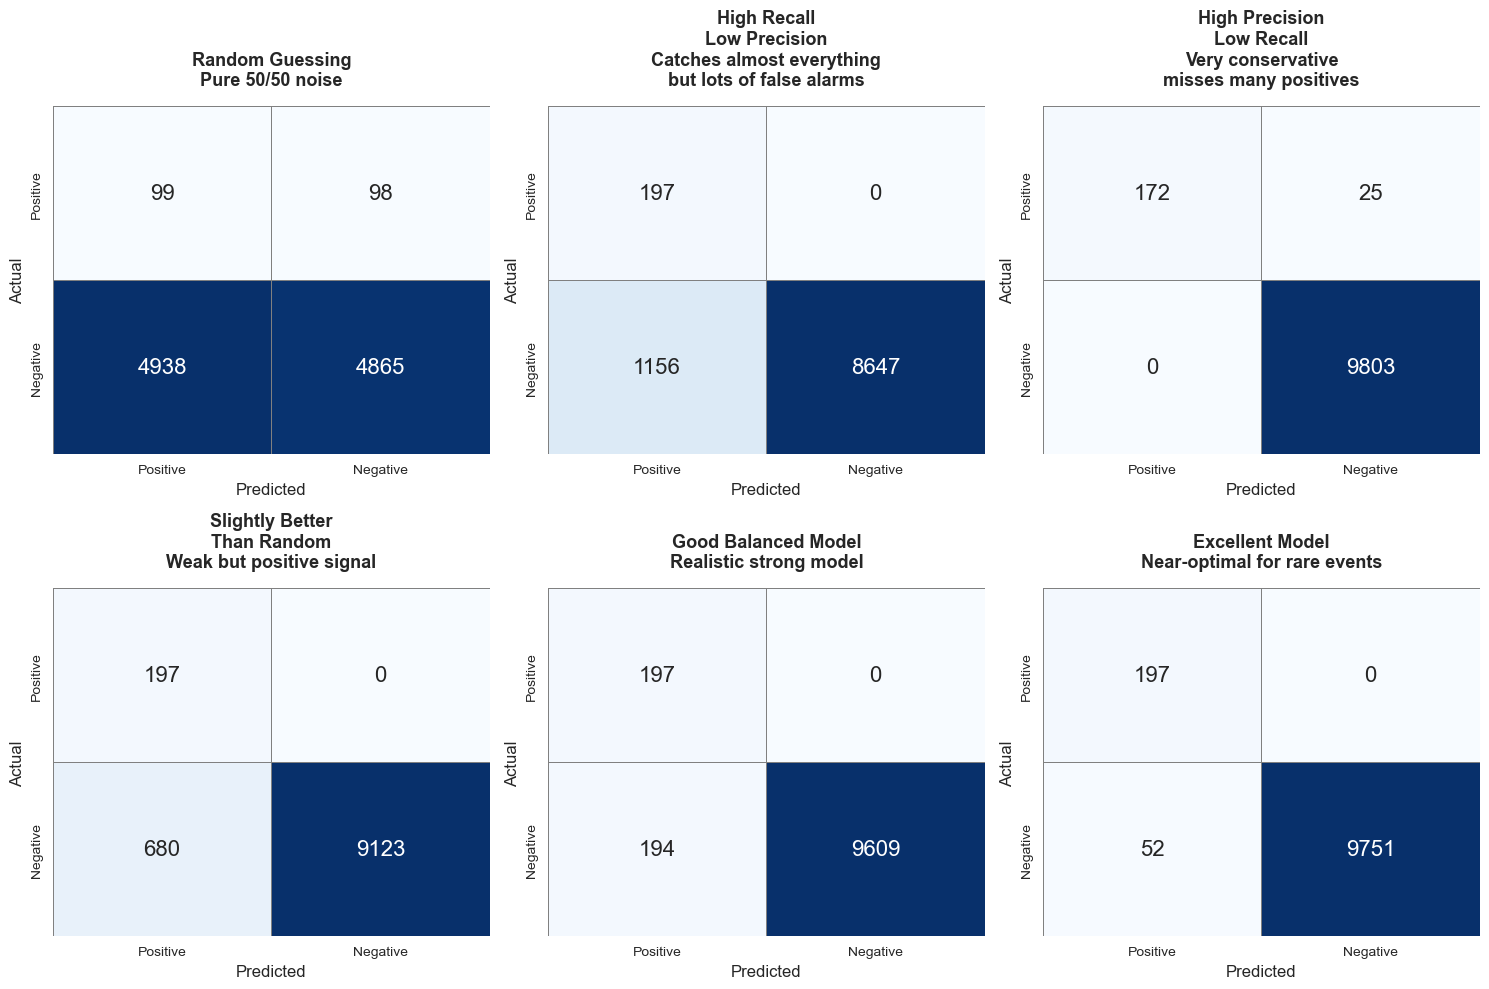


Dataset: 10,000 samples  |  197 positives (2.0% prevalence)

SUMMARY COMPARISON (Rare Events – 2% Positive Class)
                      Model  TP   FP  FN   TN Precision Recall    F1  F0.5    F2  Accuracy
            Random Guessing  89 4850 108 4953     0.018  0.452 0.035 0.022 0.078    0.5042
  High Recall Low Precision 197 1121   0 8682     0.149  1.000 0.260 0.180 0.468    0.8879
  High Precision Low Recall 161    0  36 9803     1.000  0.817 0.899 0.957 0.848    0.9964
Slightly Better Than Random 197  684   0 9119     0.224  1.000 0.365 0.265 0.590    0.9316
        Good Balanced Model 197  186   0 9617     0.514  1.000 0.679 0.570 0.841    0.9814
            Excellent Model 197   45   0 9758     0.814  1.000 0.897 0.845 0.956    0.9955


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style("white")
sns.set_palette("husl")

def fbeta_score(precision, recall, beta=1.0):
    if precision == 0 and recall == 0:
        return 0.0
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-12)

def plot_confusion_matrix(y_true, y_pred, title="", ax=None):
    cm = confusion_matrix(y_true, y_pred)
    # Standard medical/ML order: Positive on top/left
    cm_reordered = np.array([[cm[1,1], cm[1,0]],  # TP   FN
                             [cm[0,1], cm[0,0]]]) # FP   TN
    
    sns.heatmap(cm_reordered, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Positive', 'Negative'],
                yticklabels=['Positive', 'Negative'],
                annot_kws={"size": 16}, linewidths=0.5, linecolor='gray', ax=ax)
    
    ax.set_title(title, fontsize=13, pad=15, weight='bold')
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)

# =============================================================================
# Data + Models (rare events ≈2%)
# =============================================================================

np.random.seed(42)
n_samples = 10_000
prevalence = 0.02
y_true = np.random.choice([1, 0], size=n_samples, p=[prevalence, 1-prevalence])
n_pos = y_true.sum()

examples = [
    ("Random Guessing", "Pure 50/50 noise", 
     lambda y: np.random.randint(0, 2, size=len(y))),
    
    ("High Recall\nLow Precision", "Catches almost everything\nbut lots of false alarms", 
     lambda y: (y == 1) | (np.random.random(len(y)) < 0.12)),
    
    ("High Precision\nLow Recall", "Very conservative\nmisses many positives", 
     lambda y: (y == 1) & (np.random.random(len(y)) < 0.85)),
    
    ("Slightly Better\nThan Random", "Weak but positive signal", 
     lambda y: y | (np.random.random(len(y)) < 0.07)),
    
    ("Good Balanced Model", "Realistic strong model", 
     lambda y: (y == 1) | ((y == 0) & (np.random.random(len(y)) < 0.018))),
    
    ("Excellent Model", "Near-optimal for rare events", 
     lambda y: (y == 1) | ((y == 0) & (np.random.random(len(y)) < 0.005))),
]

# =============================================================================
# Plots
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (name, desc, func) in enumerate(examples):
    y_pred = func(y_true).astype(int)
    plot_confusion_matrix(y_true, y_pred, title=f"{name}\n{desc}", ax=axes[i])

plt.tight_layout()
plt.show()

# =============================================================================
# FINAL SUMMARY TABLE – NOW WITH TP/FP/FN/TN
# =============================================================================

results = []
for name, _, func in examples:
    y_pred = func(y_true).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    results.append({
        'Model'      : name.replace('\n', ' '),
        'TP'         : tp,
        'FP'         : fp,
        'FN'         : fn,
        'TN'         : tn,
        'Precision': f"{precision:.3f}",
        'Recall'     : f"{recall:.3f}",
        'F1'         : f1_score(y_true, y_pred, zero_division=0),
        'F0.5'       : fbeta_score(precision, recall, 0.5),
        'F2'         : fbeta_score(precision, recall, 2.0),
        'Accuracy'   : accuracy_score(y_true, y_pred),
    })

df = pd.DataFrame(results)

# Nice formatting
df_summary = df[['Model', 'TP', 'FP', 'FN', 'TN', 'Precision', 'Recall', 'F1', 'F0.5', 'F2', 'Accuracy']]
df_summary = df_summary.round({'F1': 3, 'F0.5': 3, 'F2': 3, 'Accuracy': 4})

print(f"\nDataset: {n_samples:,} samples  |  {n_pos} positives ({prevalence:.1%} prevalence)\n")
print("="*110)
print("SUMMARY COMPARISON (Rare Events – 2% Positive Class)")
print("="*110)
print(df_summary.to_string(index=False))